In [2]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(ggpubr)
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: prodlim

 randomForestSRC 2.9.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: RColorBrewer
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:randomForestSRC’:

    impute

The following objects are masked from ‘package:dplyr’:

    src, summarize

In [3]:
colors <- c("Components" = "#EE9937", "ELN Recommendation 2017" = "#5C5C5C", "comp" = "#870C14", "eln_comp" = "#BFBFBF",
         "eln_gen" = "#59A08B", "eln_cyto" = "#2b8cbe", "eln_gen_cyto" = "#a6bddb", "eln_gen_cyto_comp" = "#fdbb84",
         "comp_gen" = "grey45", "comp_cyto" = "#e79f00", "comp_gen_cyto" = "#009E73", "cyto" = "#0072B2",
         "gen" = "#CC79A7", "gen_cyto" = "#9ad0f3", "eln_age" = "#D55E00", "eln_demo" = "lightskyblue","eln_clin" = "mistyrose4", "eln_clin_demo" = "darkseagreen","comp_age" = "lightgoldenrod","comp_clin" = "lightsalmon","comp_demo" = "#F0E442","comp_clin_demo" = "firebrick3","comps" = "#000000")

In [23]:
### Useful function for Comparison
#  colors <- c("Components" = "#EE9937", "ELN Recommendation 2017" = "#5C5C5C", "comp" = "#870C14", "eln_comp" = "#BFBFBF",
#          "eln_gen" = "#59A08B", "eln_cyto" = "#2b8cbe", "eln_gen_cyto" = "#a6bddb", "eln_gen_cyto_comp" = "#fdbb84",
#          "comp_gen" = "grey45", "comp_cyto" = "#e79f00", "comp_gen_cyto" = "#009E73", "cyto" = "#0072B2",
#          "gen" = "#CC79A7", "gen_cyto" = "#9ad0f3", "eln_age" = "#D55E00", "eln_demo" = "lightskyblue","eln_clin" = "mistyrose4", "eln_clin_demo" = "darkseagreen","comp_age" = "lightgoldenrod","comp_clin" = "lightsalmon","comp_demo" = "#F0E442","comp_clin_demo" = "firebrick3","comps" = "#000000")

comparison <-function(models = list(c("eln","comp")), remove_RFX_ = F ,x = 25, y = 8 ,tests="",color=c("#EE9937","#5C5C5C"),FUN=median,title="",y_right=T,ylim=c(0.5,0.85) ){
       options(warn=-1)
    with_colors = T
    df_comparison <- read.table(paste(paste("Prognosis_results_MRD/",models[1],sep=""),".tsv",sep=""))
    df_comparison$model <- ifelse(models[1]=="eln","ELN Recommendation 2017",
                         ifelse(models[1]=="comp","Components",models[1]))
    for (mod in models[-1]){
        
        tmp <- read.table(paste(paste("Prognosis_results_MRD/",mod,sep=""),".tsv",sep=""))
        tmp$model <- ifelse(mod=="eln","ELN Recommendation 2017",
                         ifelse(mod=="comp","Components",mod))
        if(with_colors){
                with_colors = is.element(unique(tmp$model),names(colors))
        }
        df_comparison <- rbind(df_comparison,tmp)
    }
    df_comparison <- melt(df_comparison,id='model')
    if (remove_RFX_){df_comparison <- df_comparison[df_comparison$variable!= "RFX_",]}
    df_comparison $title <- "Detailed Comparison"
    df_comparison$title_bis <- title
    
    
    
    
    set_notebook_plot_size(x,y)
    p1 <- ggplot(df_comparison,aes(x=variable,y=value)) + geom_boxplot(aes(fill = model), notch=F)+
    theme(strip.text = element_text(size=30),legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8,size=20),axis.text.y = element_text(size = 20),
         axis.title.x=element_text(size=30),axis.title.y=element_text(size=30),legend.title=element_text(size=30),legend.text=element_text(size=20)) +
    ylab("C-Index") + xlab("") + facet_wrap( ~ title) + try(if(length(color)>1){scale_fill_manual(values=color)})+scale_y_continuous(position = "right")
    
    p2 <- ggplot(df_comparison, aes(x=reorder(model,-value,FUN=FUN),y=value))+
    geom_boxplot(aes(fill =model), notch=F)+ 
    theme(strip.text = element_text(size=30),legend.position="none",axis.text.x = element_text(vjust=0.8,size=15),axis.text.y = element_text(size = 15),
             axis.title.x=element_text(size=30),axis.title.y=element_text(size=30),legend.title=element_text(size=30),legend.text=element_text(size=20))+
     stat_compare_means(paired=F,comparison=tests,method="wilcox.test")+
    xlab("")+ylab("C-Index")+ facet_wrap( ~ title_bis) +scale_fill_manual(values=color) 
    if(y_right==T){
        p2 <- p2 + scale_y_continuous(position = "right",limits = ylim) 
    } else {
        p2 <- p2 +theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+ scale_y_continuous(position = "right",limits = ylim) 
    }
    return(p1)
#     return(p2)
}

# TMP FIGURES

#### Conclusion:

It seems that adding MRD does not really add value to genes or comp or eln 

Overall end points , MRD adds value to RFS

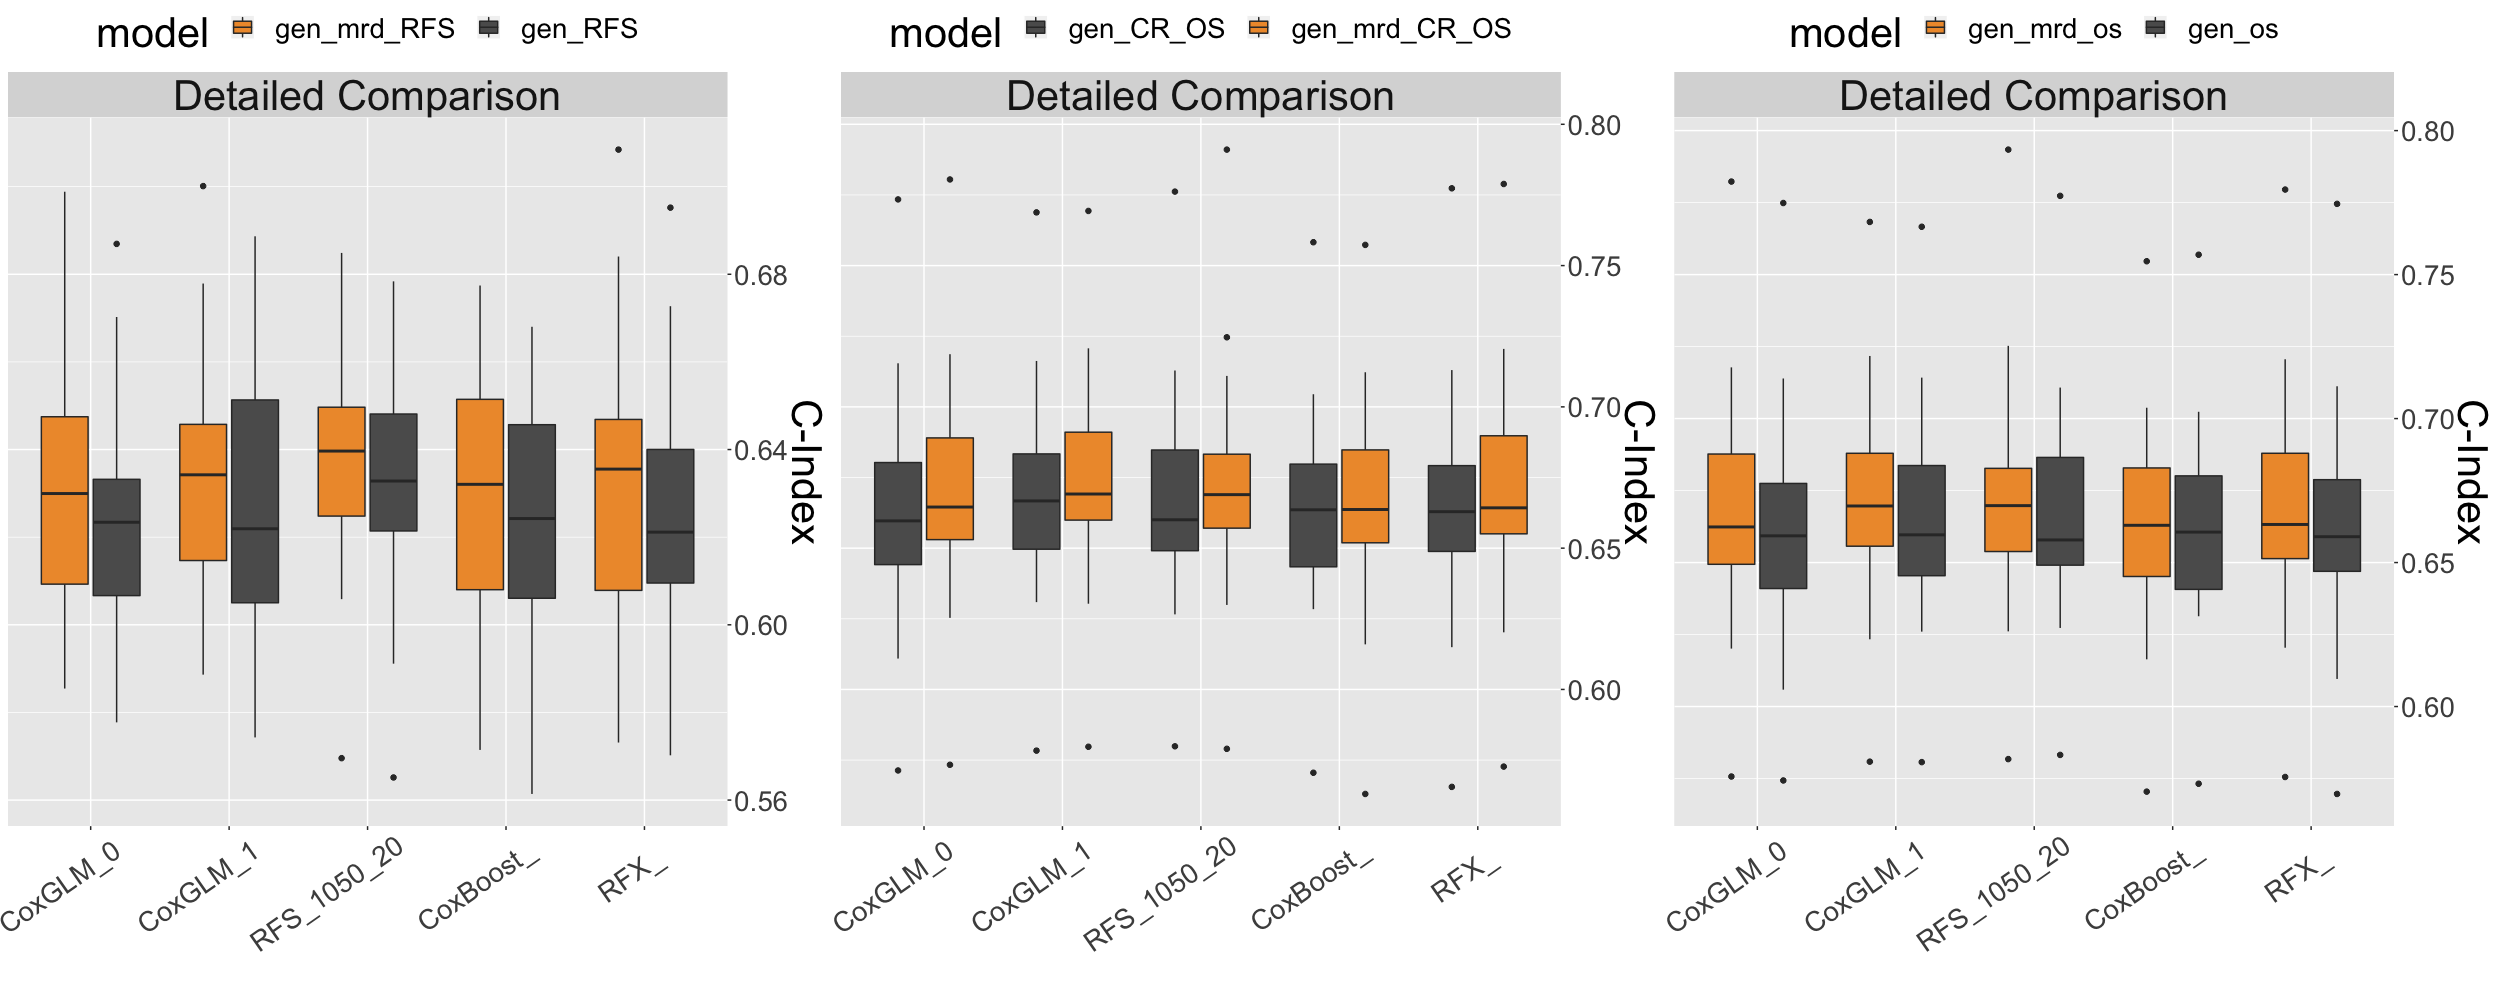

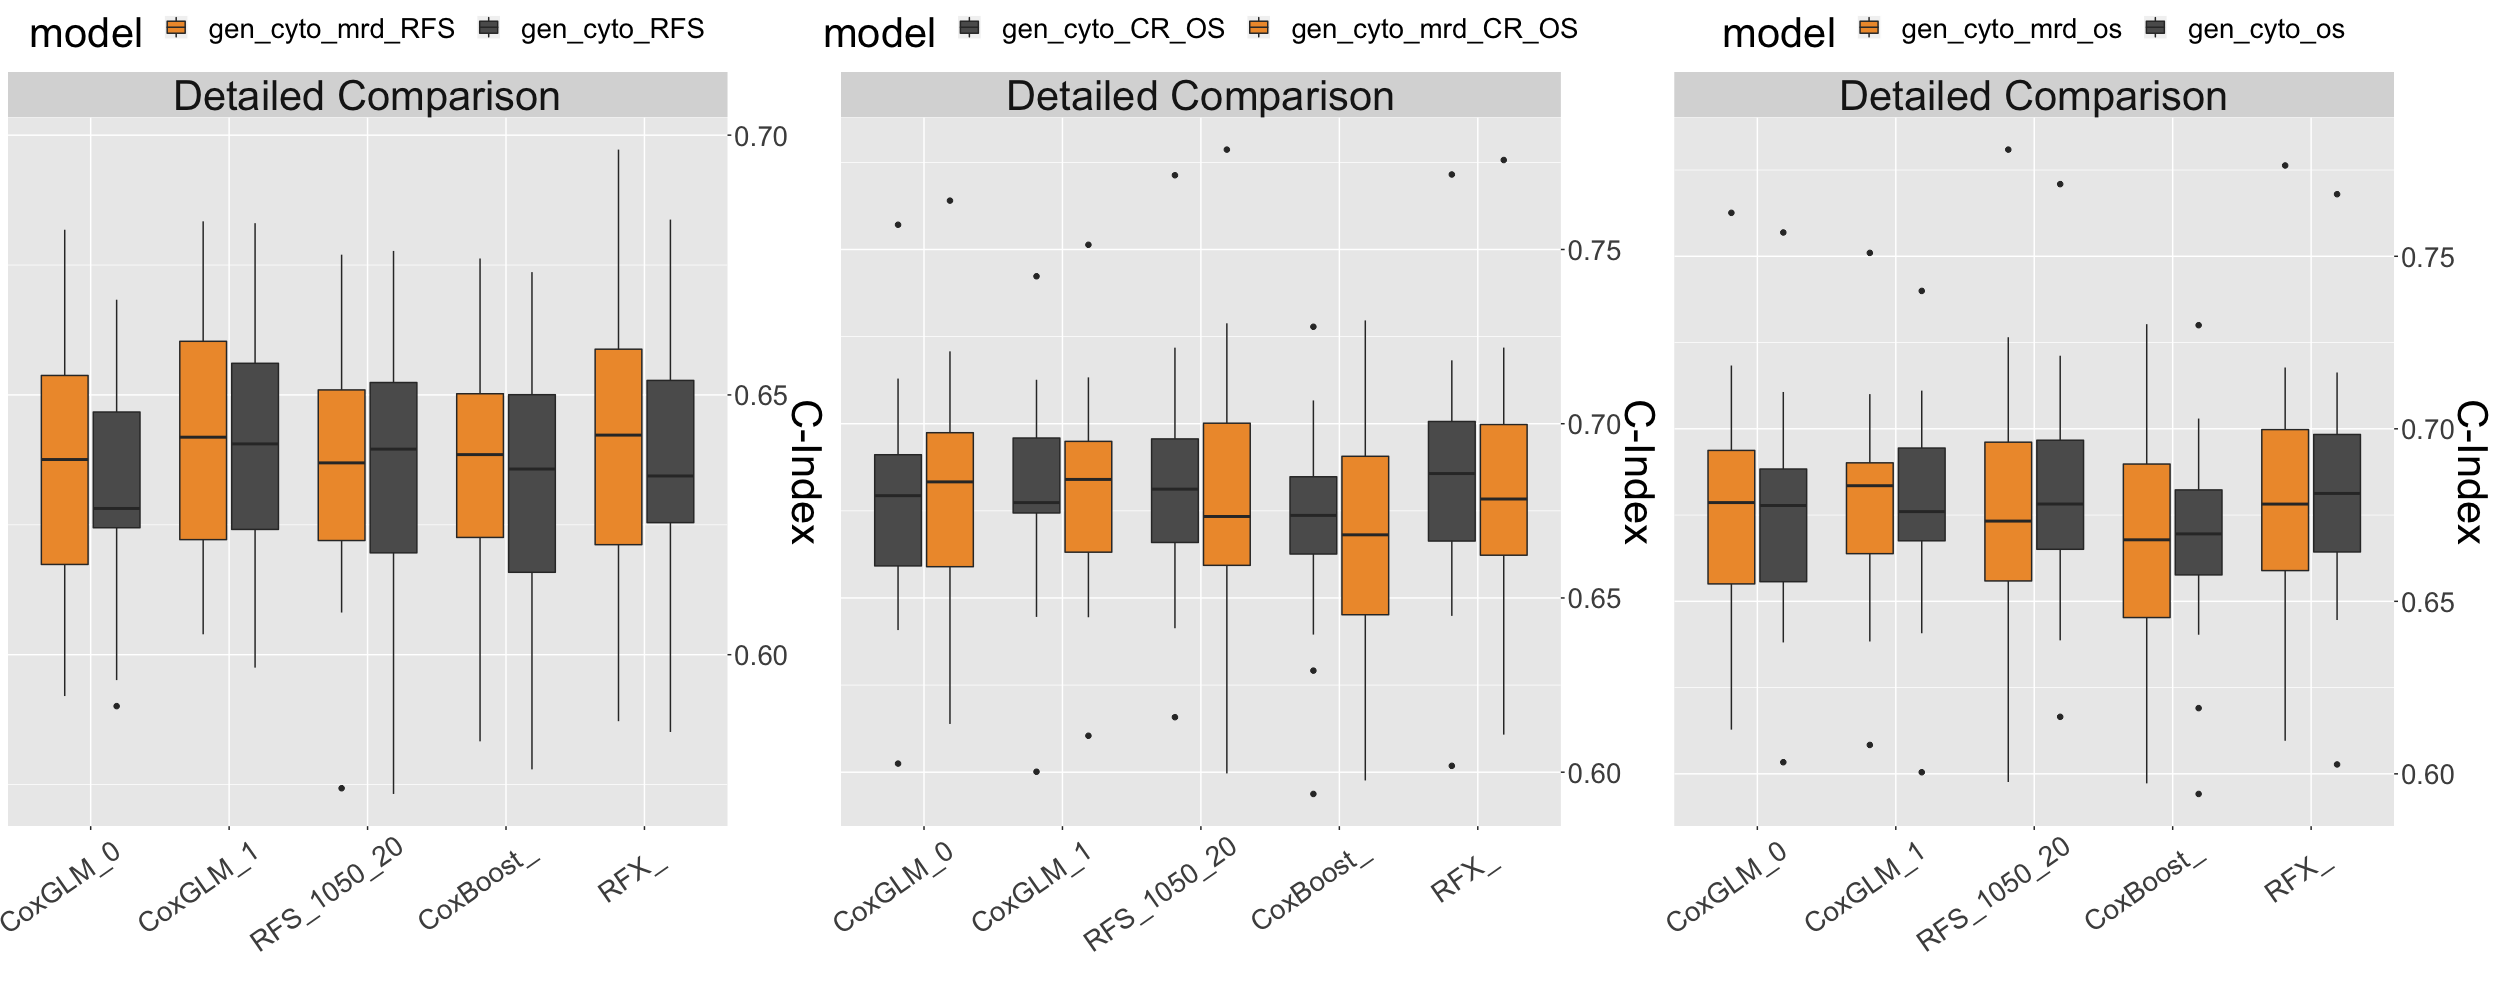

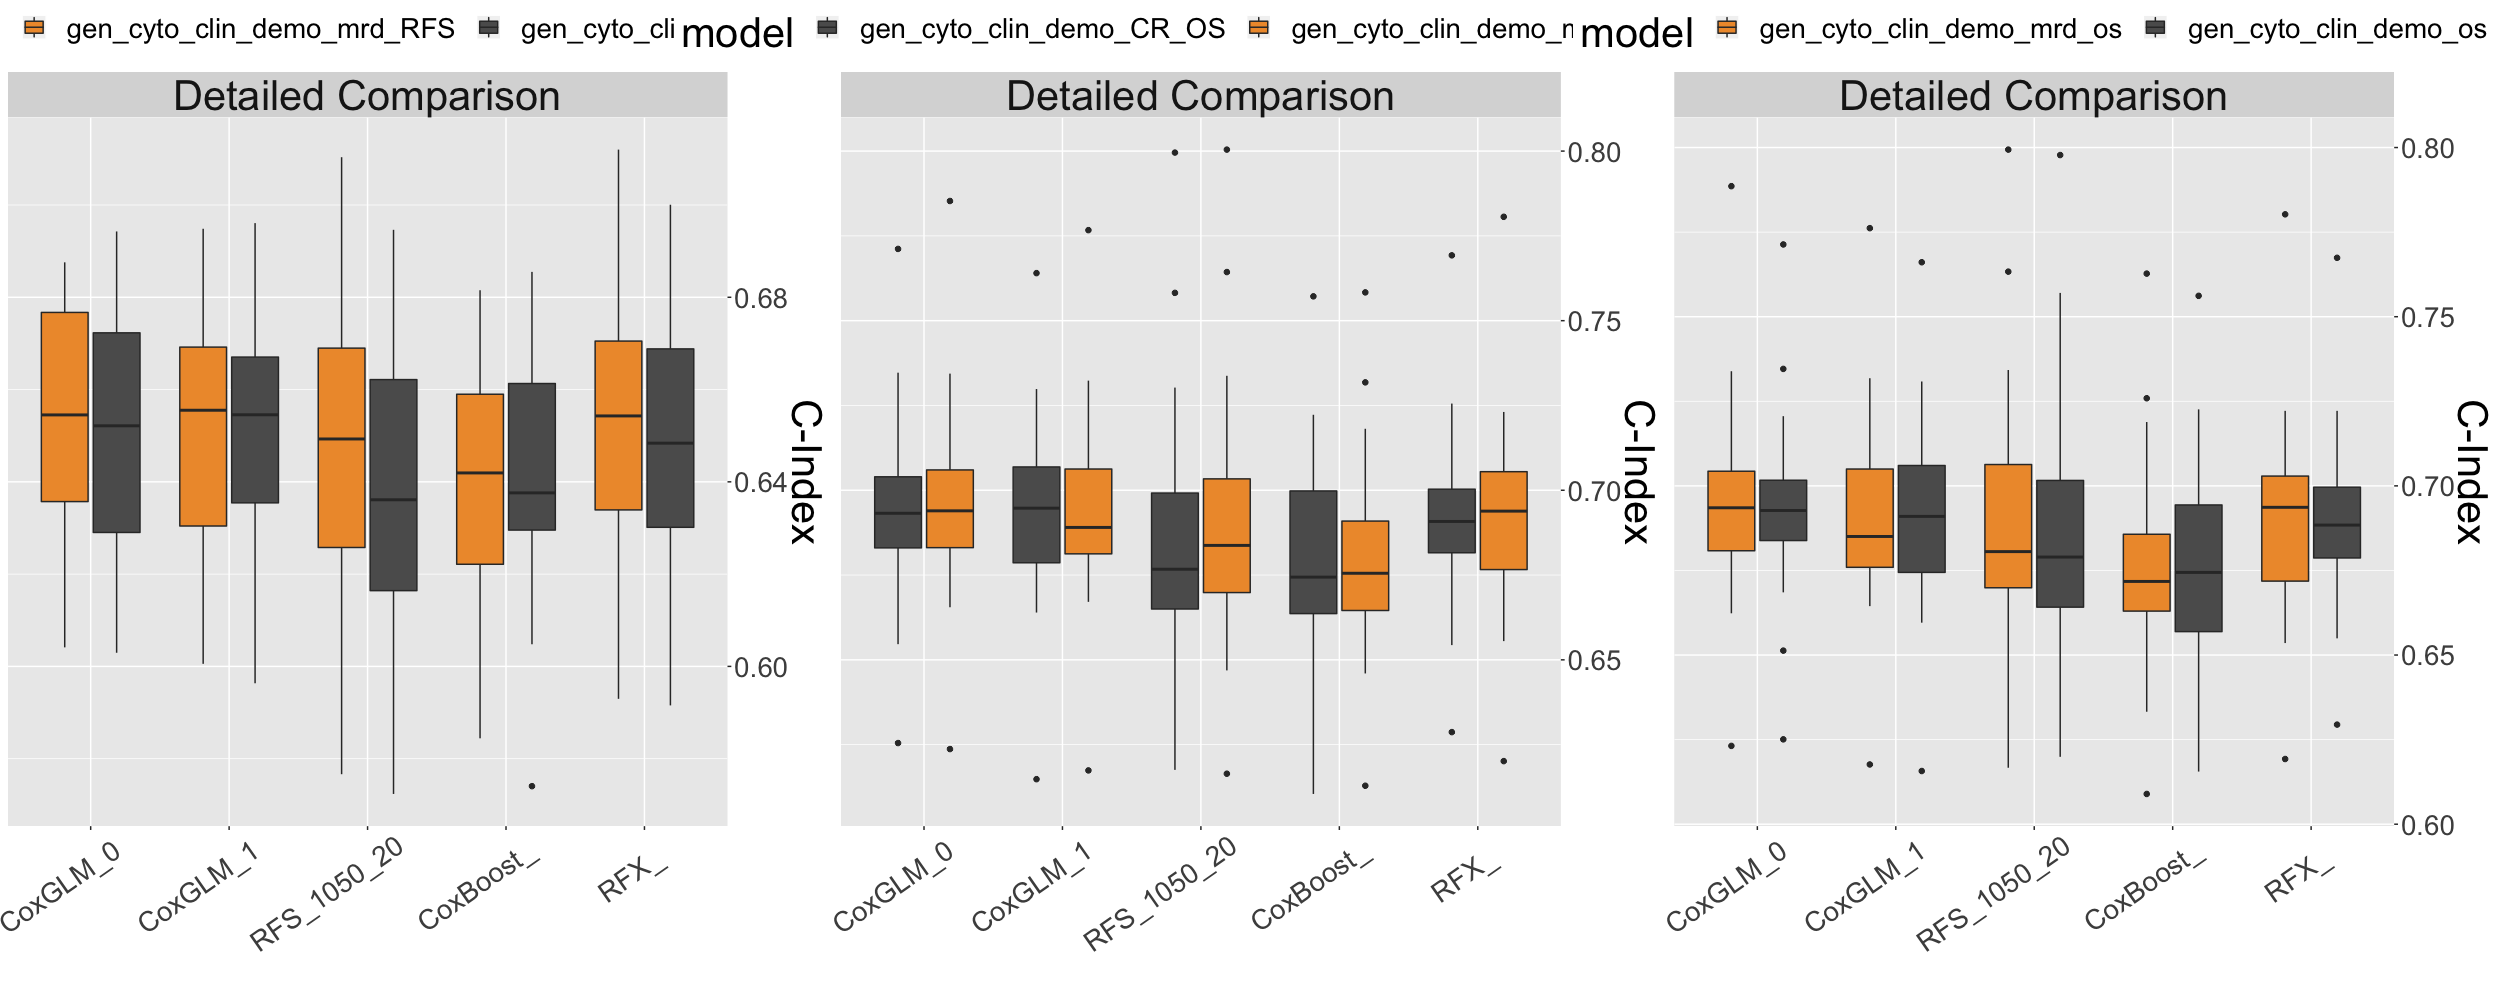

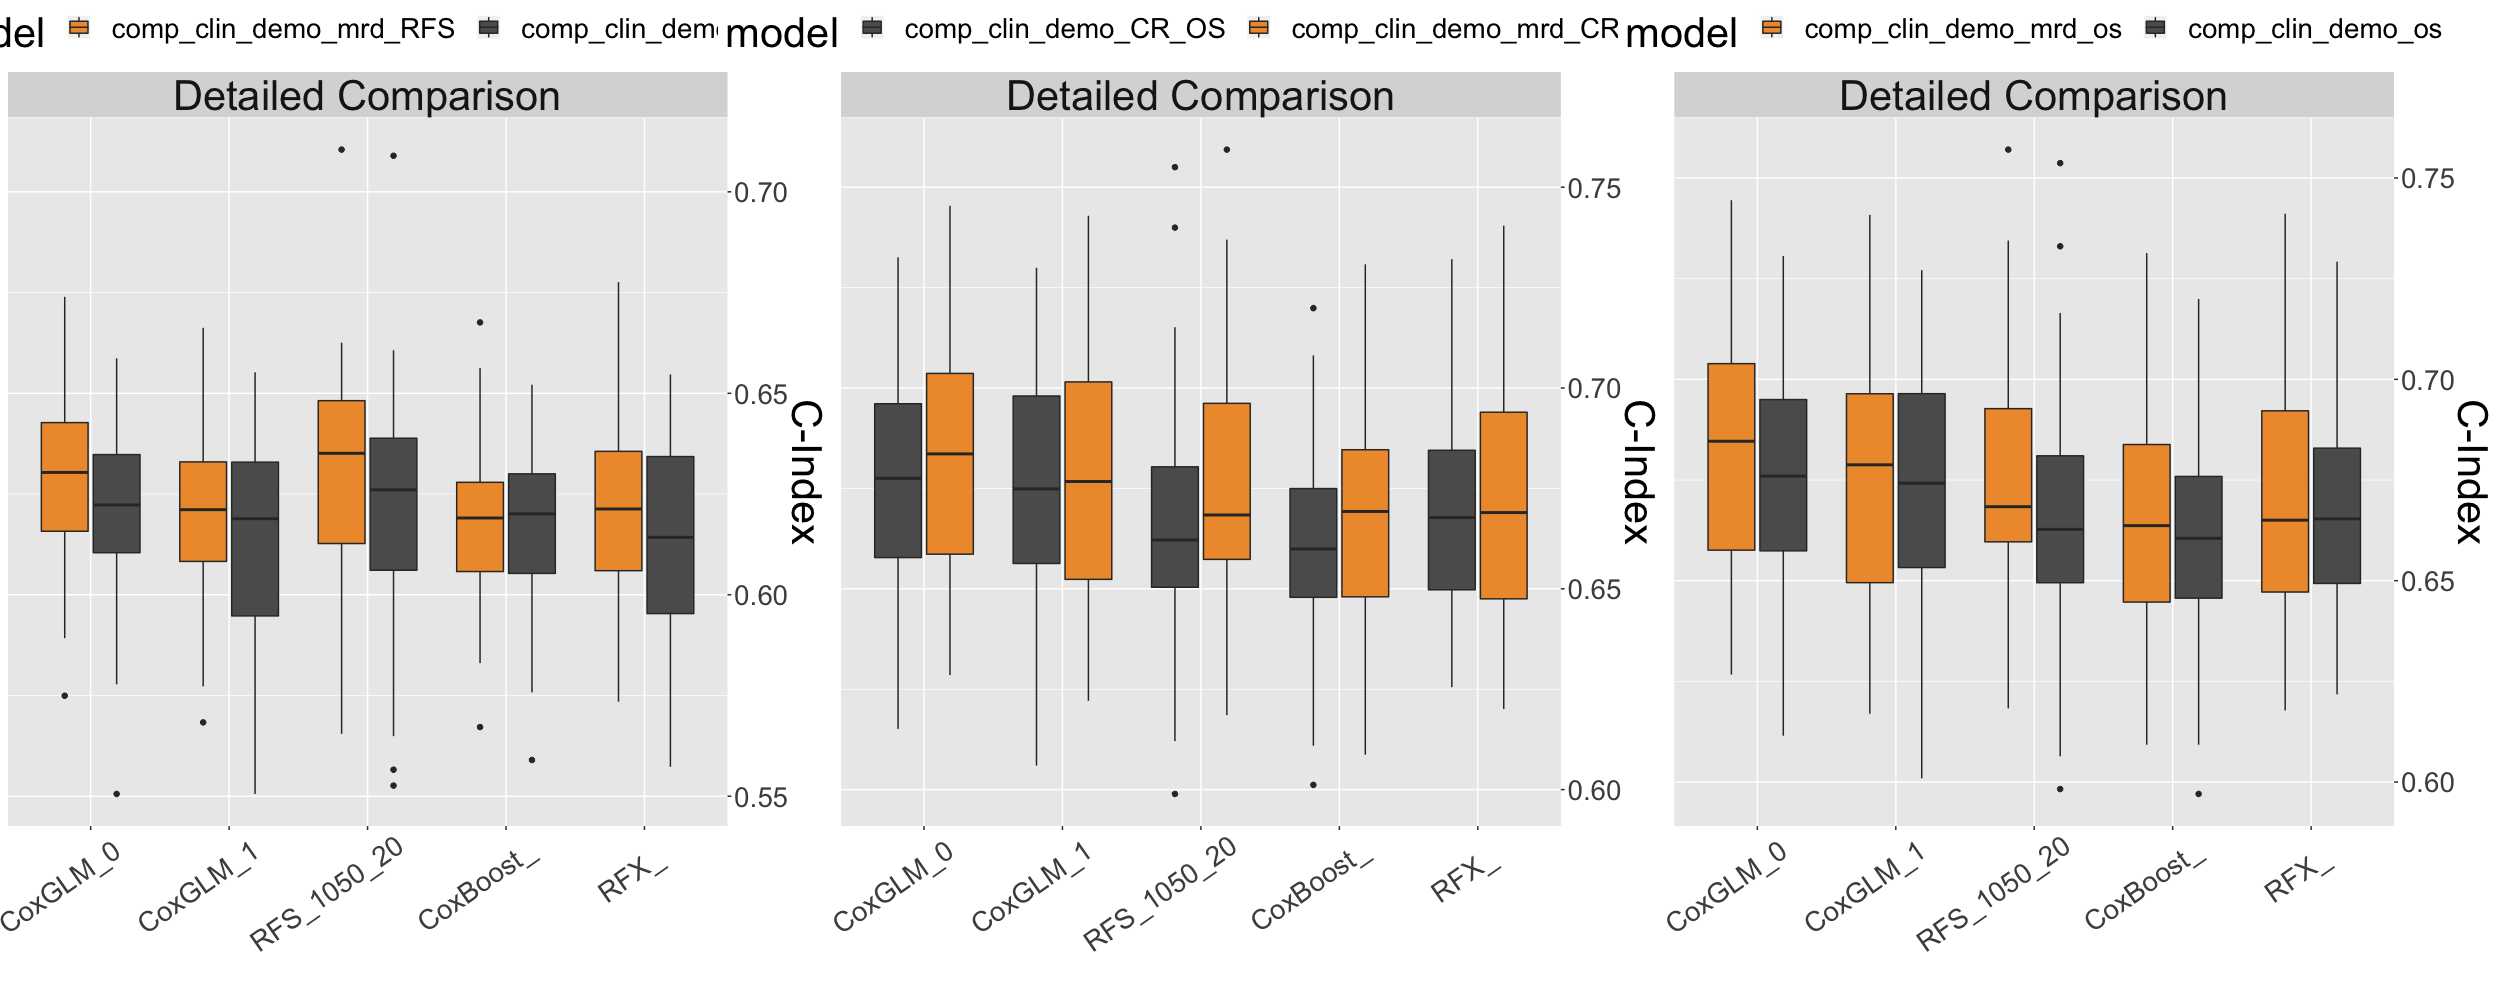

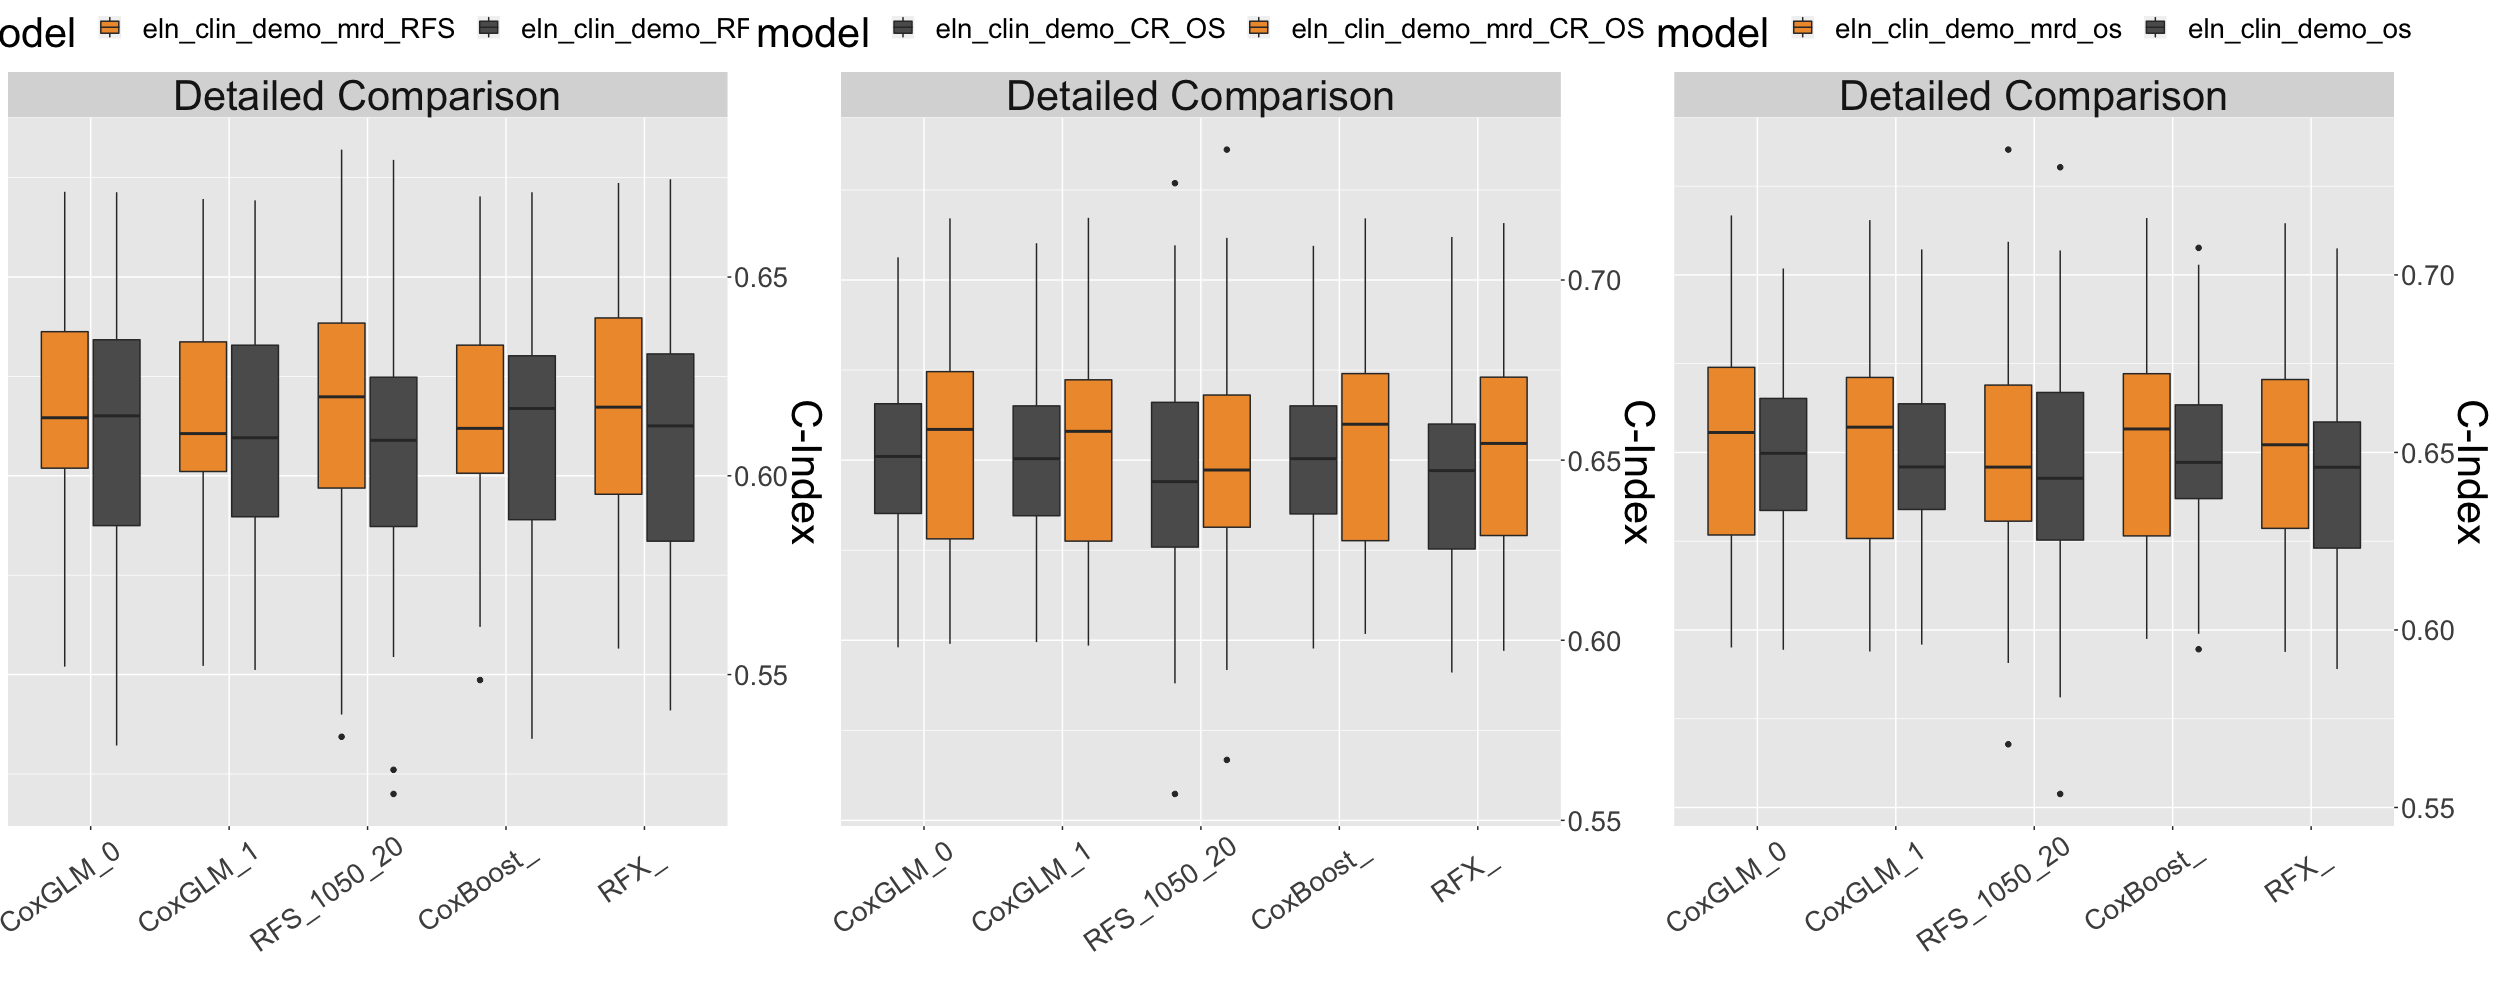

In [28]:

for (co in c("gen","gen_cyto","gen_cyto_clin_demo","comp_clin_demo","eln_clin_demo")){
    grid.arrange(
                    comparison(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep="")),tests=list(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep=""))),title="Relapse free",y=10,y_right=F),
                    comparison(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep="")),tests=list(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep=""))),color = c("#5C5C5C","#EE9937"),title="OS_CR",y=10,y_right=F),
                    comparison(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep="")),tests=list(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep=""))),title="OS",y=10,y_right=T),nrow=1)
}

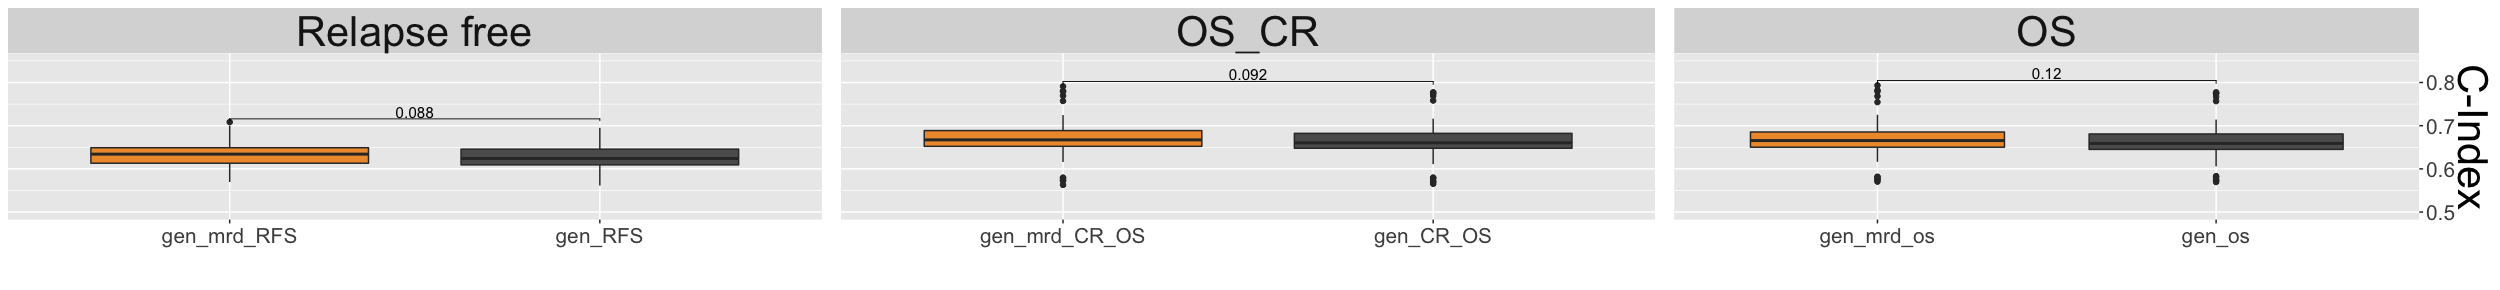

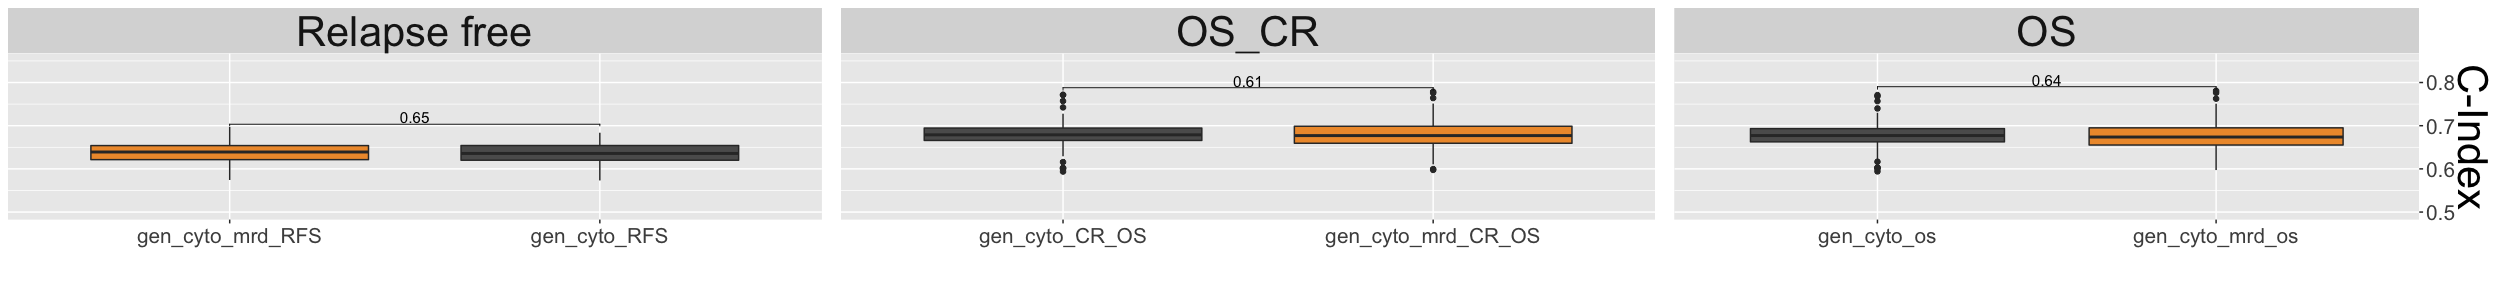

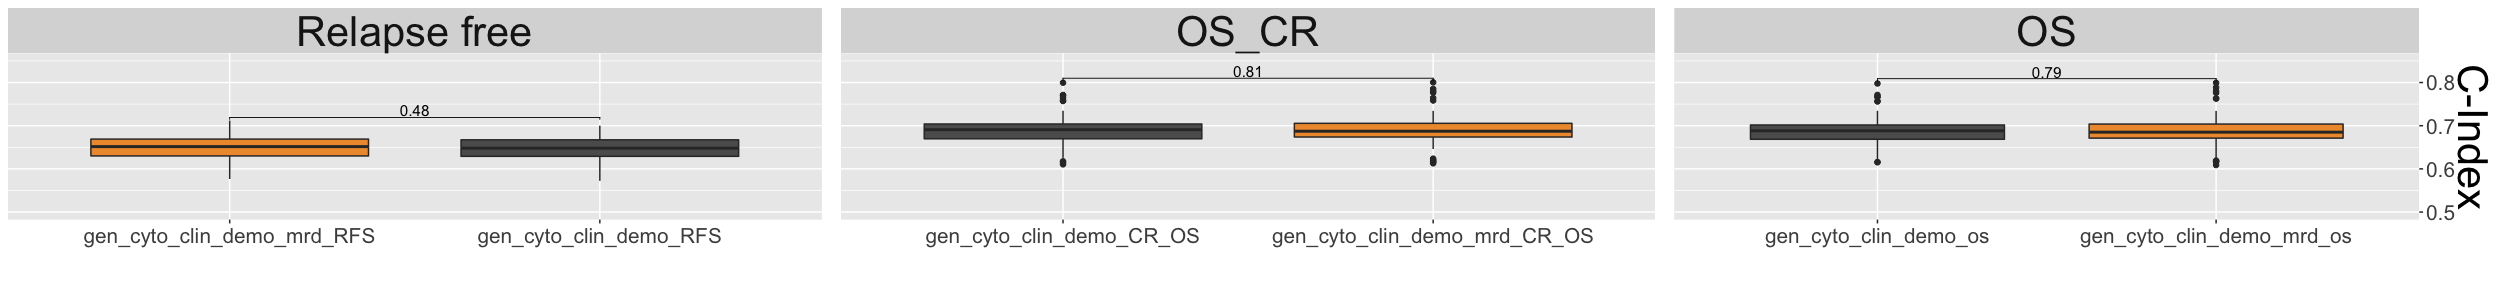

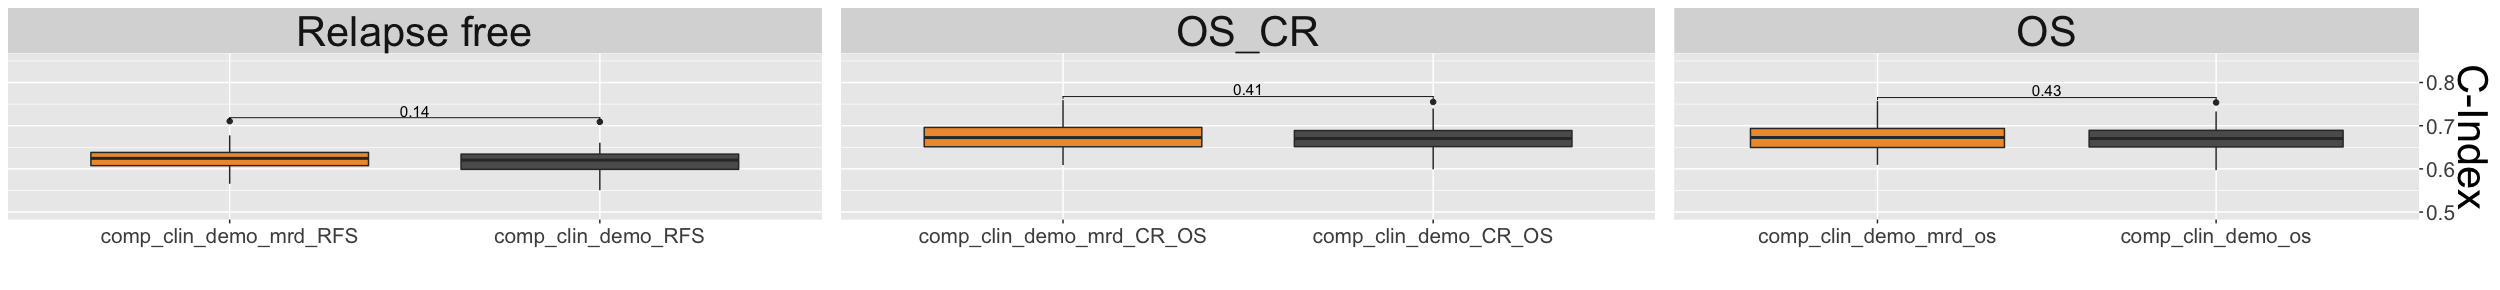

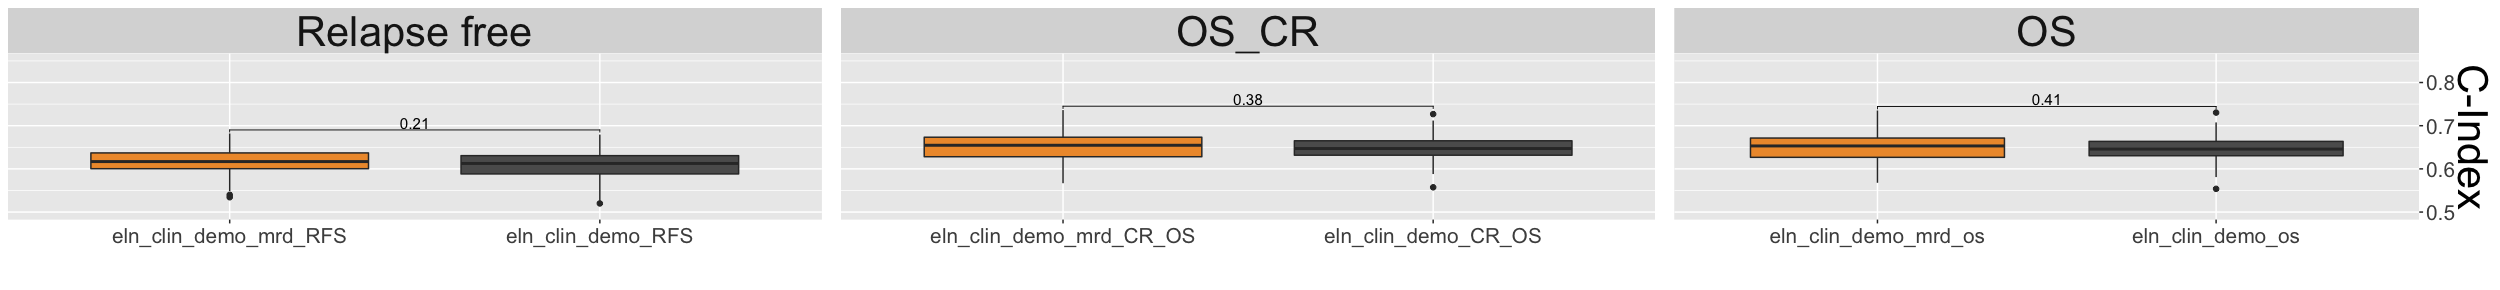

In [108]:
all <- c("eln","comp","gen","cyto","clin","demo","clin_demo","gen_cyto","gen_cyto_clin_demo","comp_clin_demo","eln_clin_demo")
for (co in c("gen","gen_cyto","gen_cyto_clin_demo","comp_clin_demo","eln_clin_demo")){
    grid.arrange(
                    comparison(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep="")),tests=list(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep=""))),title="Relapse free",y=2.9,y_right=F),
                    comparison(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep="")),tests=list(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep=""))),color = c("#5C5C5C","#EE9937"),title="OS_CR",y=2.9,y_right=F),
                    comparison(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep="")),tests=list(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep=""))),title="OS",y=2.9,y_right=T),nrow=1)
}

# ELN COMP

In [11]:
set_notebook_plot_size(30,20)
p_RFS <- list()
p_OS_CR <- list()
p_OS <- list()
for (co in c("eln","comp")){
    p_RFS[[co]] <- comparison(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep="")),tests=list(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep=""))),title="Relapse free",y=8,y_right=F)
    p_OS_CR[[co]] <- comparison(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep="")),tests=list(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep=""))),color = c("#5C5C5C","#EE9937"),title="OS_CR",y=8,y_right=F)
    p_OS[[co]] <- comparison(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep="")),tests=list(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep=""))),title="OS",y=8,y_right=T)
}
png("comparison_eln_comp.png",width=8000,3125,res=400)
grid.arrange(p_RFS[["eln"]],p_OS_CR[["eln"]],p_OS[["eln"]],p_RFS[["comp"]],p_OS_CR[["comp"]],p_OS[["comp"]],nrow=2)
dev.off()

pdf 
  2

# CYTO CLIN DEMO CLIN DEMO

In [15]:
set_notebook_plot_size(30,20)
p_RFS <- list()
p_OS_CR <- list()
p_OS <- list()
for (co in c("cyto","clin","demo","clin_demo")){
    p_RFS[[co]] <- comparison(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep="")),tests=list(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep=""))),title="Relapse free",y=8,y_right=F)
    p_OS_CR[[co]] <- comparison(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep="")),tests=list(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep=""))),color = c("#5C5C5C","#EE9937"),title="OS_CR",y=8,y_right=F)
    p_OS[[co]] <- comparison(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep="")),tests=list(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep=""))),title="OS",y=8,y_right=T)
}
png("comparison_cyto_clin_demo_clin_demo.png",width=6000,4160,res=400)
grid.arrange(p_RFS[["cyto"]],p_OS_CR[["cyto"]],p_OS[["cyto"]],p_RFS[["clin"]],p_OS_CR[["clin"]],p_OS[["clin"]],
             p_RFS[["demo"]],p_OS_CR[["demo"]],p_OS[["demo"]],p_RFS[["clin_demo"]],p_OS_CR[["clin_demo"]],p_OS[["clin_demo"]],nrow=4)
dev.off()

pdf 
  2

# GEN GEN CYTO GEN CYTO CLIN DEMO COMP CLIN DEMO ELN CLIN DEMO

In [21]:
set_notebook_plot_size(30,20)
p_RFS <- list()
p_OS_CR <- list()
p_OS <- list()
for (co in c("gen","gen_cyto","gen_cyto_clin_demo","comp_clin_demo","eln_clin_demo")){
    p_RFS[[co]] <- comparison(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep="")),tests=list(c(paste(co,"_RFS",sep=""),paste(co,"_mrd_RFS",sep=""))),title="Relapse free",y=8,y_right=F)
    p_OS_CR[[co]] <- comparison(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep="")),tests=list(c(paste(co,"_CR_OS",sep=""),paste(co,"_mrd_CR_OS",sep=""))),color = c("#5C5C5C","#EE9937"),title="OS_CR",y=8,y_right=F)
    p_OS[[co]] <- comparison(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep="")),tests=list(c(paste(co,"_os",sep=""),paste(co,"_mrd_os",sep=""))),title="OS",y=8,y_right=T)
}
png("comparison_others.png",width=6000,4160,res=290)
grid.arrange(p_RFS[["gen"]],p_OS_CR[["gen"]],p_OS[["gen"]],p_RFS[["gen_cyto"]],p_OS_CR[["gen_cyto"]],p_OS[["gen_cyto"]],
             p_RFS[["gen_cyto_clin_demo"]],p_OS_CR[["gen_cyto_clin_demo"]],p_OS[["gen_cyto_clin_demo"]],p_RFS[["comp_clin_demo"]],p_OS_CR[["comp_clin_demo"]],p_OS[["comp_clin_demo"]],
             p_RFS[["eln_clin_demo"]],p_OS_CR[["eln_clin_demo"]],p_OS[["eln_clin_demo"]],nrow=5)
dev.off()

pdf 
  2